In [1]:
"""
This is a demo of the findings in the paper:
Language Models Implement Simple Word2Vec-Style Vector Arithmetic
and will run through the main result, which is that while solving some task,
e.g, recalling the capital city of some location, a language model 
(GPT2-medium in this case) will predict that city by transforming the country name
into the capital with an additive update:
Poland+o_city=Warsaw
and that the exact vector the model infers to do this (o_city) implements the same
function on other examples when we add it to the residual stream of the forward
pass, e.g., China+o_cirt=Beijing
"""

'\nThis is a demo of the findings in the paper:\nLanguage Models Implement Simple Word2Vec-Style Vector Arithmetic\nand will run through the main result, which is that while solving some task,\ne.g, recalling the capital city of some location, a language model \n(GPT2-medium in this case) will predict that city by transforming the country name\ninto the capital with an additive update:\nPoland+o_city=Warsaw\nand that the exact vector the model infers to do this (o_city) implements the same\nfunction on other examples when we add it to the residual stream of the forward\npass, e.g., China+o_cirt=Beijing\n'

In [1]:
from modeling import *
import matplotlib.pyplot as plt

In [3]:
model, tokenizer = load_gpt2('gpt2')

In [4]:
model = model.float()

In [5]:
wrapper = GPT2Wrapper(model, tokenizer)

In [6]:
def tokenize(text):
    inp_ids = wrapper.tokenize(text)
    str_toks = wrapper.list_decode(inp_ids[0])
    return inp_ids, str_toks

In [8]:
kbicr_prompt = "Alice lives in France, Paris - Alice, John lives in Germany, Berlin - John, Peter lives in USA, Washington -"

kbicr_ids, kbicr_pos = tokenize(kbicr_prompt)

In [9]:
logits = wrapper.get_layers(kbicr_ids)
wrapper.print_top(logits[1:]) #skip the embedding layer

0  -_- The A General I And -- Died May
1  -_- The Died Special A ‎ Monaco Mes Ver
2 _- Special Mult The Mes none ‎ Died - Ver
3  Mult Mes New Great Ser Times Ver_- NTS Columbia
4  Ver Mes Mult Termin Great End Hear Go South New
5  The Art Ver Nay Columb Est A Her Termin New
6  The A Art Her Great Nay D Ham An Top
7  John Sam Nick Roger Michael Carl Sergey Adam Ibid Jim
8  John Peter Thomas Michael Roger James Robert Sam Luke Tony
9  Peter John PetePeter Thomas Roger Robert Paul Mark Michael
10  Peter John Pete Paul Thomas JamesPeter Roger Robert Michael
11  Peter John Paul James Thomas Alice Roger Pete Robert David


In [12]:
"""
We can decode at the residual stream between the attention and FFN to show that 
it is the FFN update that updates from Poland to Warsaw, but a slightly easier way to do this is to
subtract the FFN update that was applied at layer 19 to show the intermediate residual stream state
(i.e., between the attention and FFN)
"""

wrapper.add_hooks()
out = wrapper.model(input_ids = kbicr_ids, output_hidden_states=True) #run it again to activate hooks
logits = out.logits
hidden_states = out.hidden_states
hidden_states = list(hidden_states)[1:] #skip the embedding layer to stay consistent with our indexing

#get the FFN output update at layer 9
o_person = wrapper.model.activations_['mlp_9']

print(len(hidden_states)) # 13

layer_logits = wrapper.layer_decode(hidden_states)
layer_logits = torch.stack(layer_logits).squeeze(-1)
print("Original top tokens at layer 9")
wrapper.print_top(layer_logits[9].unsqueeze(0))

hidden_states[9]-=o_person 


layer_logits = wrapper.layer_decode(hidden_states)
layer_logits = torch.stack(layer_logits).squeeze(-1)
print("After subtracting mlp_9 (o_person)")
wrapper.print_top(layer_logits[9].unsqueeze(0))

#Now we can see that the prediction at layer 9 has gone from Warsaw to Poland

12
Original top tokens at layer 9
0  Peter John PetePeter Thomas Roger Robert Paul Mark Michael
After subtracting mlp_9 (o_person)
0  PeterPeter John Pete Thomas Roger Mark Paul Robert Tom


In [15]:
"""
before showing that mlp_19 promotes capital cities in general, we can show that mlp_19 can interact with other layers
within the same input

We can use o_person to manipulate the other layers that are either in argument formation (representing " Poland")
or in saturation (representing " Warsaw"). We can try to flip these states so that all of the arguments become
the output " Warsaw" and the saturated states go back to the argument " Poland"

""" 

out = wrapper.model(input_ids = kbicr_ids, output_hidden_states=True) #run it again to activate hooks
logits = out.logits
hidden_states = out.hidden_states
hidden_states = list(hidden_states)[1:]

layer_logits = wrapper.layer_decode(hidden_states)
layer_logits = torch.stack(layer_logits).squeeze(-1)

print("Original: most likely tokens starting at layer 7:")
wrapper.print_top(layer_logits[7:])

print("----")
#We can add o_person to go from Poland to Warsaw, and subtract to go from Warsaw to Poland

#We find that when we intervene at a single later layer (>19), we have to scale the vector up
#and for some reason, it tends to need to scale down at the last layer
#in the paper, this is partly why we apply the interventions at multiple layers in a row, so that
#it accumulates in the forward pass.
hidden_states[7]+=o_person
hidden_states[8]+=o_person
hidden_states[9]-=2*o_person 
hidden_states[10]-=4*o_person 
hidden_states[11]-=.9*o_person #The last layer can be weird. Play around with this scaling factor to see

layer_logits = wrapper.layer_decode(hidden_states)
layer_logits = torch.stack(layer_logits).squeeze(-1)
#As you can see, we can flip every token from Warsaw to Poland or vice versa 
#except for layer 7 with +/- o_person, with some scaling for the later layers
print("After intervention: Most likely tokens starting at layer 7:")
wrapper.print_top(layer_logits[7:])

Original: most likely tokens starting at layer 7:
0  John Sam Nick Roger Michael Carl Sergey Adam Ibid Jim
1  John Peter Thomas Michael Roger James Robert Sam Luke Tony
2  Peter John PetePeter Thomas Roger Robert Paul Mark Michael
3  Peter John Pete Paul Thomas JamesPeter Roger Robert Michael
4  Peter John Paul James Thomas Alice Roger Pete Robert David
----
After intervention: Most likely tokens starting at layer 7:
0  John Roger James Robert Michael David William Nick Jim Carl
1  John Peter Robert Roger Thomas James Michael William Richard David
2  PeterPeter John Pete Thomas Mark Parker Tom Roger Patt
3  PeterPeter John New The Pa No O Parker Port
4  Kasich Poster Kaine Holland Unsure Netherlands Bots Rooney Teach Lens


In [16]:
"""
Next we will show that o_city works to promote other capital cities in totally different contexts
e.g., transforming China into Beijing where the context does not cue the model that Beijing might be important

We will perform the o vector intervention described in the paper, in which we replace FFN blocks entirely,
substituting their updates with the precomputed o vector (in this case o_city)
"""

#first we will store the normal FFN layers so that we can restore the model later
mlps = []
for i in range(len(wrapper.model.transformer.h)):
    mlps.append(wrapper.model.transformer.h[i].mlp)
    
def reset_mlps():
    for i in range(len(wrapper.model.transformer.h)):
        wrapper.model.transformer.h[i].mlp = mlps[i]
        





In [17]:
#start the intervention at layer 18 and apply it to all of the following layers
layer_idx = 8

def o_intervention(o_func, layer_idx):
    for i in range(layer_idx,11): #Note: change these to change which layers are intervened on
        wrapper.model.transformer.h[i].mlp = LambdaLayer(lambda x: o_func) #instead of outputting FFN(x), output o_func
    

In [18]:
"""
First, let's show what we are trying to do:
given some repeating pattern of random tokens with some subject token mixed in, we
can take advantage of the fact that when predicting the next instance of the subject token,
the model will represent that subject token in some middle layer, giving us a chance to intervene
"""

china_text = "table mug free China table mug free China table mug free"
reset_mlps()
china_ids, china_toks = tokenize(china_text)
cntrl_china_logits = wrapper.get_layers(china_ids)
#Let's just look at the most likely token per layer to make it clear
wrapper.print_top(cntrl_china_logits, k=1)
#as you can see, the prediction is already China by layer 15, we can introduce an intervention to add o_city to some
#range of these layers to try to transform it into Beijing
#we will essentially perform the operation China+o_city=Beijing
#where o_city is the FFN update that had originally transformed Poland into Warsaw

0  free
1  free
2  free
3  free
4  free
5 bies
6 bies
7 bies
8  China
9  China
10  China
11  China
12  China


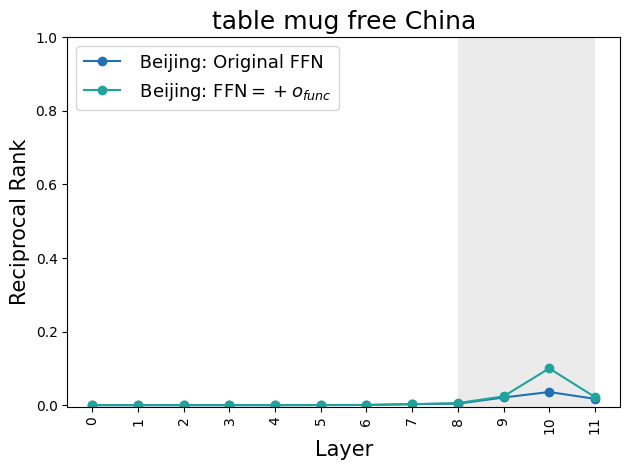

In [20]:
#For this result we will plot the reciprocal ranks of the tokens we are interested in within the vocab distributions
#These tokens are the original country (argument: China) and the corresponding capital (output: Beijing)

def plot_rrs_before_and_after_intervention(before_rrs, after_rrs, title, label, line_idx=None):
    colors = [
        [0.12710496, 0.44018454, 0.70749712, 1.        ], #Original FFN 
        [0.12710496, 0.64018454, 0.60749712, 1.        ], #FFN$=+o_{func}$
    ]
    plt.title(title, fontsize=18)
    plt.xticks(np.arange(12), np.arange(12), rotation=90)
    plt.plot(before_rrs[1:], label=f'{label}: Original FFN', marker='o', color=colors[0]) #Why [1:]? rrs[0] is the embedding table step
    plt.plot(after_rrs[1:], label=f'{label}:'+' FFN$=+o_{func}$', marker='o', color=colors[1]) #Why [1:]? rrs[0] is the embedding table step

    if line_idx is not None:
        plt.axvspan(line_idx, 11, facecolor='.92')
    plt.legend(fontsize=13)
    plt.xlabel("Layer", fontsize=15)
    plt.ylabel("Reciprocal Rank", fontsize=15)
    plt.yticks([0.,.2,.4,.6,.8,1.], ['0.0','0.2','0.4','0.6','0.8','1.0'])
    plt.tight_layout()
    #plt.show()


#paper_o_city = torch.tensor(np.load('ovectors/gpt2medium/city_capital_o19_gpt2-medium.npy')).squeeze(0)

cntrl_rrs = wrapper.rr_per_layer(cntrl_china_logits, ' Beijing')

o_intervention(o_person.unsqueeze(0), layer_idx)

interv_china_logits = wrapper.get_layers(china_ids)
interv_rrs = wrapper.rr_per_layer(interv_china_logits, ' Beijing')

plot_rrs_before_and_after_intervention(cntrl_rrs, interv_rrs, ' '.join(china_text.split()[:4]), " Beijing", line_idx=layer_idx)
#You should see that even on this nonsense input, Beijing gets promoted from very low in the vocab to the top spot
#in the last layer

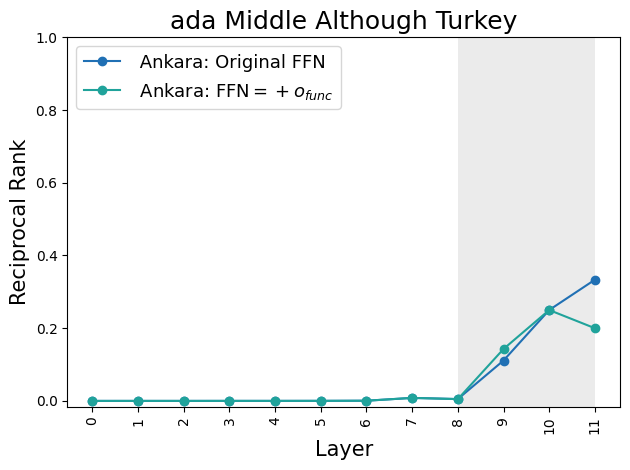

In [30]:
# We can repeat this with other examples as well. It might not always promote to most likely prediction in the last
# layer, but you should virtually always see an increase in the corresponding capital
country_text = f"ada Middle Although Turkey ada Middle Although Turkey ada Middle Although"
def reset_mask(nheads=12): # gpt-2 no. of heads / layer
    headmask = torch.ones(len(wrapper.model.transformer.h),nheads)
    return headmask
reset_mlps()
country_ids, country_toks = tokenize(country_text)
cntrl_country_logits = wrapper.get_layers(country_ids)

cntrl_rrs = wrapper.rr_per_layer(cntrl_country_logits, ' Ankara')

o_intervention(o_person.unsqueeze(0), layer_idx)

interv_country_logits = wrapper.get_layers(country_ids)
interv_rrs = wrapper.rr_per_layer(interv_country_logits, ' Ankara')

plot_rrs_before_and_after_intervention(cntrl_rrs, interv_rrs, ' '.join(country_text.split()[:4]), " Ankara", line_idx=layer_idx)
plt.savefig('turkey.pdf')



In [23]:
"""
We also find that we can find an update like this that uppercases the first letter of tokens.
In this example, we find that the model uses the in-context ' brown' token to later get the
final answer " Brown"
"""
reset_mlps()
wrapper.add_hooks()
colors_text = """Q: On the floor, I see a silver keychain, a red pair of sunglasses, a gold sheet of paper, a black dog leash, and a blue cat toy. What color is the keychain?
A: Silver
Q: On the table, you see a brown sheet of paper, a red fidget spinner, a blue pair of sunglasses, a teal dog leash, and a gold cup. What color is the sheet of paper?
A:"""


colors_ids, colors_toks = tokenize(colors_text)
colors_logits = wrapper.get_layers(colors_ids)[1:]

#If you were to print out these logits, you would see that it seems like the 
#model never actually goes through argument formation.
#wrapper.print_top(colors_logits)

#However, if we decode at the residual stream right before the FFN update,
#you'll see that it represents ' brown' in only this spot.
#Here we show how to decode at the intermediate residual stream (between attention and FFN)

inter_logits = []
for i in range(len(wrapper.model.transformer.h)):
    inter_logits.append(wrapper.model.activations_['intermediate_residual_'+str(i)])
inter_logits = torch.stack(inter_logits).unsqueeze(1)
inter_logits = torch.stack(wrapper.layer_decode(inter_logits)).squeeze(-1)
print("Intermediate residual at layer 19:")
wrapper.print_top(inter_logits[7].unsqueeze(0))
print("Final hidden state at layer 19:")
wrapper.print_top(colors_logits[7].unsqueeze(0))

#We don't claim that argument formation/function application is used to solve  
#every example, but it's worth mentioning cases where it can occur very briefly
o_upper = wrapper.model.activations_['mlp_7']


Intermediate residual at layer 19:
0  None Nothing Probably Yes Mostly Well Very They The Oh
Final hidden state at layer 19:
0  None Nothing Unknown Probably Mostly Yes Very Clear Light Same


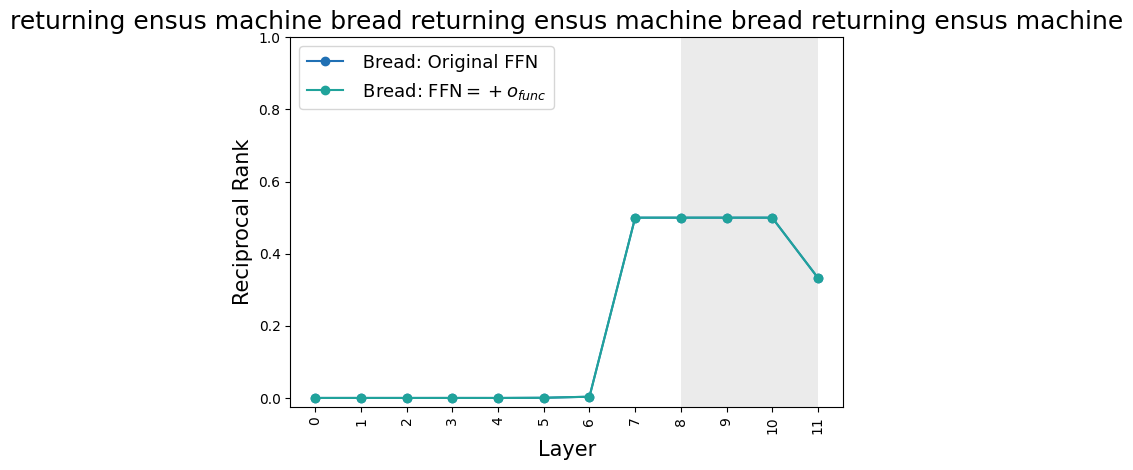

In [24]:
#here we will uppercase a token totally unrelated to the previous context: " bread" to " Bread"

uppper_text = f"returning ensus machine bread returning ensus machine bread returning ensus machine"
def reset_mask(nheads=12):
    headmask = torch.ones(len(wrapper.model.transformer.h),nheads)
    return headmask

reset_mlps()
uppper_ids, uppper_toks = tokenize(uppper_text)
cntrl_uppper_logits = wrapper.get_layers(uppper_ids)

cntrl_rrs = wrapper.rr_per_layer(cntrl_uppper_logits, ' Bread')

o_intervention(o_upper.unsqueeze(0), layer_idx)

interv_uppper_logits = wrapper.get_layers(uppper_ids)
interv_rrs = wrapper.rr_per_layer(interv_uppper_logits, ' Bread')

plot_rrs_before_and_after_intervention(cntrl_rrs, interv_rrs, uppper_text, " Bread", line_idx=layer_idx)


" Bread" [28731]
" Crouch" [327, 48626] [' C', 'rouch']


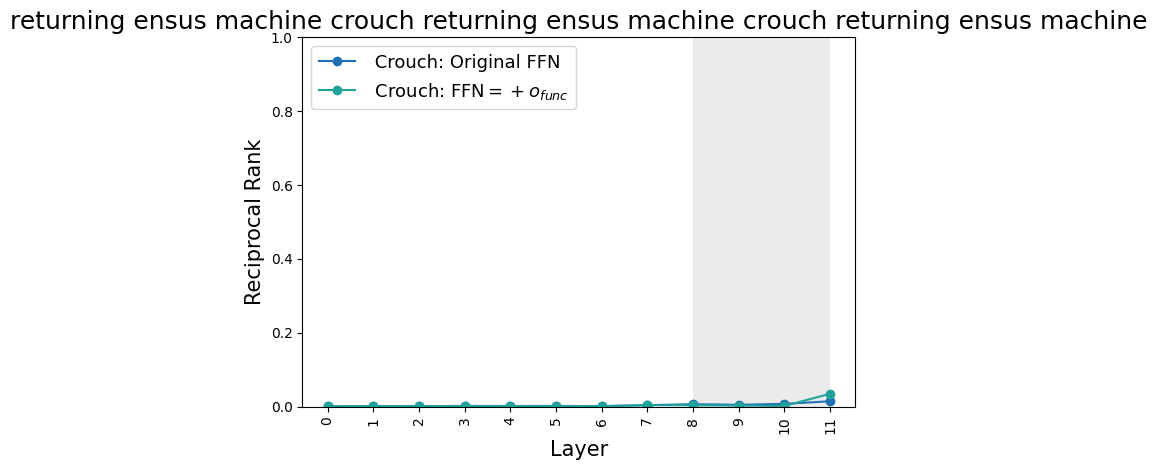

In [25]:
"""
We find that the uppercasing o vector performs the most consistently out of the other two we tested.
One common failure point we saw for all three, however, is when either the argument or output tokens
are broken up into multiple tokens. For example, " crouch" is one token, but the capitalized form " Crouch"
is split into the tokens " C"+"rouch". It would be surprising if the relationship between " crouch" and " C" 
was encoded the same way as e.g., " bread" and " Bread", and we see that cases like these tend to react
more poorly to the intervention. Cases where a token maps to a single capital letter like these are particularly
challenging.
See Appendix E of the paper for an analysis on the effects of tokenization.
"""
tokens_Crouch =wrapper.tokenizer.encode(" Crouch")
print('" Bread"', wrapper.tokenizer.encode(" Bread"))
print('" Crouch"', tokens_Crouch, [wrapper.tokenizer.decode([t]) for t in tokens_Crouch])

uppper_text = f"returning ensus machine crouch returning ensus machine crouch returning ensus machine"
def reset_mask(nheads=12):
    headmask = torch.ones(len(wrapper.model.transformer.h),nheads)
    return headmask

reset_mlps()
uppper_ids, uppper_toks = tokenize(uppper_text)
cntrl_uppper_logits = wrapper.get_layers(uppper_ids)

cntrl_rrs = wrapper.rr_per_layer(cntrl_uppper_logits, ' Crouch')

o_intervention(o_upper.unsqueeze(0), layer_idx)

interv_uppper_logits = wrapper.get_layers(uppper_ids)
interv_rrs = wrapper.rr_per_layer(interv_uppper_logits, ' Crouch')

plot_rrs_before_and_after_intervention(cntrl_rrs, interv_rrs, uppper_text, " Crouch", line_idx=layer_idx)

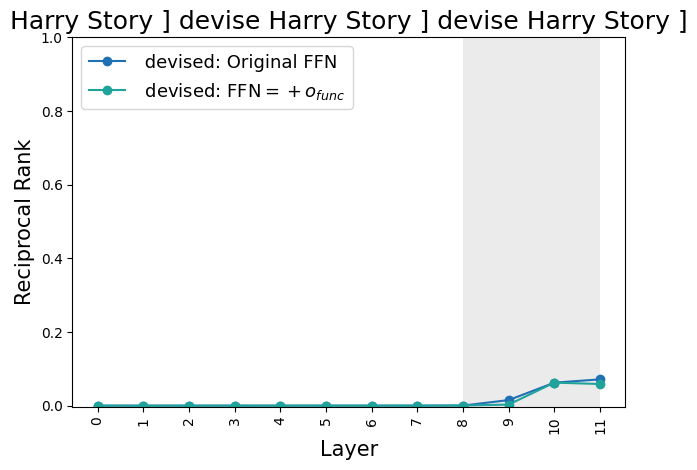

In [26]:
"""
Lastly, we can use a similar update to promote past tense verbs. We find that this update promotes past tensing 
in general, but doesn't promote the past tense verb all the way to to the top of the distribution as often
(only about 8% of the time).
"""
reset_mlps()
pt1 = "Today I abandon. Yesterday I abandoned. Today I abolish. Yesterday I"
pt_ids, pt_toks = tokenize(pt1)
pt_logits=wrapper.get_layers(pt_ids)
o_past = wrapper.model.activations_['mlp_6'] # 7 -1 

pt_text  = "Harry Story ] devise Harry Story ] devise Harry Story ]"
pt_ids, pt_toks = tokenize(pt_text)

reset_mlps()
cntrl_pt_logits = wrapper.get_layers(pt_ids)
cntrl_rrs = wrapper.rr_per_layer(cntrl_pt_logits, ' devised')

#paper_o_past = torch.tensor(np.load('ovectors/gpt2medium/regular_past_o18_gpt2-medium.npy')).squeeze(0)
o_intervention(o_past.unsqueeze(0), layer_idx)

interv_pt_logits = wrapper.get_layers(pt_ids)
interv_rrs = wrapper.rr_per_layer(interv_pt_logits, ' devised')

plot_rrs_before_and_after_intervention(cntrl_rrs, interv_rrs, pt_text, " devised", line_idx=layer_idx)